<h1 style="text-align:center;">MACHINE LEARNING - II</h1>

Now, that we have our base models ready we will try to tune them to find the best possible set of hyperparamters for each model

## Import Libraries

In [1]:
# Future warning suppresor
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import shutil
import os
from joblib import dump
from io import StringIO
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from matplotlib import cm

from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

## Get Data

In [2]:
# Get data files
X_train = np.load('data/scaled/X_train.npy')
X_valid = np.load('data/scaled/X_valid.npy')
y_train = np.load('data/scaled/y_train.npy')
y_valid = np.load('data/scaled/y_valid.npy')

# Get scores dataframe
scores = pd.read_csv('data/scores.csv', header=[0, 1], index_col = 0)

In [3]:
scores

Iteration         Base Model           Tuned Model      
Accuracy               Train     Valid       Train Valid
GaussianNB          0.862821  0.862319         0.0   0.0
SVC                 0.917949  0.869565         0.0   0.0
KNN                 0.900000  0.884058         0.0   0.0
Decision Trees      1.000000  0.789855         0.0   0.0
Random Forest       1.000000  0.869565         0.0   0.0
Gradient Boosting   0.946154  0.869565         0.0   0.0
MLP Classifier      0.946154  0.869565         0.0   0.0

## Results functions

In [4]:
# Output template
OUTPUT_TEMPLATE = (
    'Classifier :  {name}\n'
    'Train Score:  {train_score:.3f}\n'
    'Valid Score:  {valid_score:.3f}\n'
)

def outData(results):
    print(OUTPUT_TEMPLATE.format(
        name=results[0],
        train_score=results[1],
        valid_score=results[2],
        ))

    print("Classification Report:")
    print(classification_report(results[3], results[4]))
    print("")

## Tune Model Parameters

In [5]:
# Directory to save tuned models
if not os.path.exists("models/tuned"):
    print("Initiated Tuned Models directory!")
    os.makedirs("models/tuned")
else:
    print("Tuned Models directory already exists!")

Tuned Models directory already exists!


In [6]:
# Train Model Function
def train_model(model, modelName, X_train, y_train, X_valid, y_valid):
    model = model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    valid_score = model.score(X_valid, y_valid)
    outData([modelName, 
             model.score(X_train, y_train),
             model.score(X_valid, y_valid),
             y_valid,
             model.predict(X_valid),
             model.predict_proba(X_valid)])
    print("\nConfusion Matrix\n")
    plot_confusion_matrix(model,X_valid,y_valid,cmap='gnuplot',normalize='true')
    plt.show()
    dump(model, 'models/tuned/' + modelName + '.joblib')
    return  (train_score, valid_score)

### 1. GaussianNB
Naive Bayes doesn't have much  hyperparameters to tune except for var_smoothening. Hence,  we'll go with that only

In [7]:
# Initiate model
model = GaussianNB()

param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}
# params_model = {'var_smoothing' : [1e-11, 1e-10, 1e-9]}
# params_model = {'var_smoothing': [0.00000001, 0.000000001, 0.00000001]}


grid_model = GridSearchCV(estimator=model, 
                 param_grid=param_grid, 
                 cv=5,   # 5-fold cross validation 
                 verbose=1, 
                 scoring='accuracy')

grid_model.fit(X_train, y_train)

params = grid_model.best_params_
print(params)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'var_smoothing': 1.0}


Classifier :  GaussianNB
Train Score:  0.867
Valid Score:  0.870

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86        62
           1       0.90      0.86      0.88        76

    accuracy                           0.87       138
   macro avg       0.87      0.87      0.87       138
weighted avg       0.87      0.87      0.87       138



Confusion Matrix



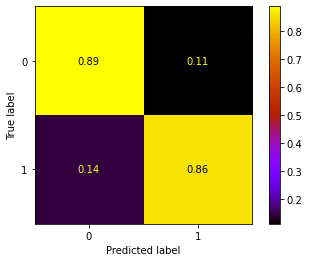

In [8]:
model = GaussianNB(var_smoothing=params['var_smoothing'])
train, valid = train_model(model, "GaussianNB", X_train, y_train, X_valid, y_valid)
scores.loc['GaussianNB', ['Tuned Model'][0]].loc['Train'] = train
scores.loc['GaussianNB', ['Tuned Model'][0]].loc['Valid'] = valid

Although, we notice a slight increase in accuracy, it isn't much so we'll be moving onto other models

### 2. SVC

In SVC, there are 3 parameters to tune, C value, gamma value and the kernel used

In [9]:
model = SVC()

param_grid = {'C': [0.1,1, 10, 100],
              'gamma': [1,0.1,0.01,0.001],
              'kernel': ['rbf', 'poly', 'sigmoid']}


grid_model = GridSearchCV(estimator=model, 
                 param_grid=param_grid, 
                 cv=5,   # 5-fold cross validation 
                 verbose=1, 
                 scoring='accuracy')

grid_model.fit(X_train, y_train)

params = grid_model.best_params_
print(params)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


Classifier :  SVC
Train Score:  0.924
Valid Score:  0.891

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88        62
           1       0.90      0.91      0.90        76

    accuracy                           0.89       138
   macro avg       0.89      0.89      0.89       138
weighted avg       0.89      0.89      0.89       138



Confusion Matrix



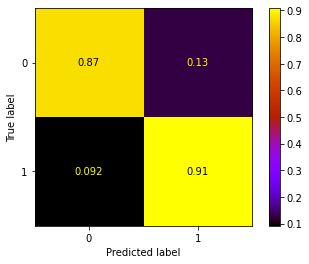

In [10]:
model = SVC(C = params['C'],
           gamma = params['gamma'],
           kernel = params['kernel'],
           probability=True)

train, valid = train_model(model, "SVC", X_train, y_train, X_valid, y_valid)
scores.loc['SVC', ['Tuned Model'][0]].loc['Train'] = train
scores.loc['SVC', ['Tuned Model'][0]].loc['Valid'] = valid

Again, we notice an improvement with these new parameters

### 3. KNearestNeighbours
The only important factor to tune in KNN is the number of neighbours, and so we'll just be tuning that

In [11]:
model = KNeighborsClassifier()

param_grid = {'n_neighbors' : list(range(1, 31))} # 1 to 30 neighbors


grid_model = GridSearchCV(estimator=model, 
                 param_grid=param_grid, 
                 cv=10,   # 10-fold cross validation 
                 verbose=1, 
                 scoring='accuracy')

grid_model.fit(X_train, y_train)

params = grid_model.best_params_
print(params)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
{'n_neighbors': 17}


Classifier :  KNN
Train Score:  0.882
Valid Score:  0.877

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86        62
           1       0.89      0.88      0.89        76

    accuracy                           0.88       138
   macro avg       0.88      0.88      0.88       138
weighted avg       0.88      0.88      0.88       138



Confusion Matrix



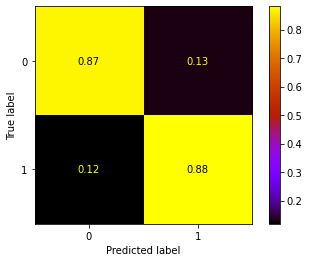

In [12]:
model = KNeighborsClassifier(n_neighbors=params['n_neighbors'])
train, valid = train_model(model, "KNN", X_train, y_train, X_valid, y_valid)
scores.loc['KNN', ['Tuned Model'][0]].loc['Train'] = train
scores.loc['KNN', ['Tuned Model'][0]].loc['Valid'] = valid

Although, we notice a slight decrease in accuracy, it should be noted that this is  performed on 10-fold validation

### 4. Decision Trees

In [13]:
model = DecisionTreeClassifier()

param_grid = {'criterion' : ['gini', 'entropy'],
              'max_depth': list(range(1,10)),
              'min_samples_split': list(range(2, 10)),
              'min_samples_leaf': list(range(1, 5))}

grid_model = GridSearchCV(estimator=model, 
                 param_grid=param_grid, 
                 cv=5,   # 5-fold cross validation 
                 verbose=1, 
                 scoring='accuracy')

grid_model.fit(X_train, y_train)

params = grid_model.best_params_
print(params)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 8}


Classifier :  Decision Trees
Train Score:  0.896
Valid Score:  0.855

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.87      0.84        62
           1       0.89      0.84      0.86        76

    accuracy                           0.86       138
   macro avg       0.85      0.86      0.85       138
weighted avg       0.86      0.86      0.86       138



Confusion Matrix



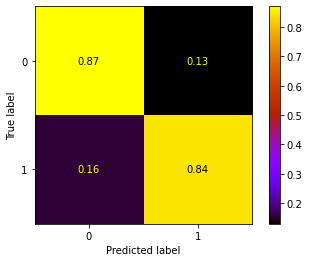

In [14]:
model = DecisionTreeClassifier(criterion = params['criterion'],
                              max_depth = params['max_depth'],
                              min_samples_leaf = params['min_samples_leaf'],
                              min_samples_split = params['min_samples_split'])

train, valid = train_model(model, "Decision Trees", X_train, y_train, X_valid, y_valid)
scores.loc['Decision Trees', ['Tuned Model'][0]].loc['Train'] = train
scores.loc['Decision Trees', ['Tuned Model'][0]].loc['Valid'] = valid

Although, the accuracy decreased from before, atleast now the model is not overfitting as it was doing earlier

### 5. Random Forest

In [15]:
## Roughly 3 minutes to run
model = RandomForestClassifier()

param_grid = {'n_estimators' : list(range(100, 301, 100)),
              'criterion' : ['gini', 'entropy'],
              'max_features' : ['auto', 'sqrt', 'log2'],
              'max_depth' : [4, 5, 6, 7, 8]}


grid_model = GridSearchCV(estimator=model, 
                 param_grid=param_grid, 
                 cv=5,   # 5-fold cross validation 
                 verbose=1, 
                 scoring='accuracy')

grid_model.fit(X_train, y_train)

params = grid_model.best_params_
print(params)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
{'criterion': 'entropy', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 100}


Classifier :  Random Forest
Train Score:  0.935
Valid Score:  0.877

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86        62
           1       0.87      0.91      0.89        76

    accuracy                           0.88       138
   macro avg       0.88      0.87      0.87       138
weighted avg       0.88      0.88      0.88       138



Confusion Matrix



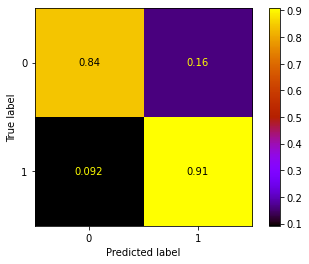

In [16]:
model = RandomForestClassifier(n_estimators = params['n_estimators'],
                              criterion = params['criterion'],
                              max_features = params['max_features'],
                              max_depth = params['max_depth'])

train, valid = train_model(model, "Random Forest", X_train, y_train, X_valid, y_valid)
scores.loc['Random Forest', ['Tuned Model'][0]].loc['Train'] = train
scores.loc['Random Forest', ['Tuned Model'][0]].loc['Valid'] = valid

Again, although we notice a decrease in accuracy, atleast our model is not overfitting as before

### 6. Gradient Boosting

In [17]:
# Roughly 3 minutes to run
model = GradientBoostingClassifier()

param_grid = {"loss":["deviance"],
              "learning_rate": [0.01, 0.025, 0.05],
              "min_samples_split": np.linspace(0.1, 0.5, 3),
              "min_samples_leaf": np.linspace(0.1, 0.5, 3),
              "max_depth":[3,5,7],
              "max_features":["log2","sqrt"],
              "criterion": ["friedman_mse"],
              "subsample":[0.5, 0.75, 1.0],
              "n_estimators":[10]
    }


# parameters = {
#     "loss":["deviance"],
#     "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
#     "min_samples_split": np.linspace(0.1, 0.5, 12),
#     "min_samples_leaf": np.linspace(0.1, 0.5, 12),
#     "max_depth":[3,5,8],
#     "max_features":["log2","sqrt"],
#     "criterion": ["friedman_mse",  "mae"],
#     "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
#     "n_estimators":list(range(100, 301, 100))
#     }


grid_model = GridSearchCV(estimator=model, 
                 param_grid=param_grid, 
                 cv=5,   # 5-fold cross validation 
                 verbose=1, 
                 scoring='accuracy')

grid_model.fit(X_train, y_train)

params = grid_model.best_params_
print(params)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
{'criterion': 'friedman_mse', 'learning_rate': 0.05, 'loss': 'deviance', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'n_estimators': 10, 'subsample': 1.0}


Classifier :  Gradient Boosting
Train Score:  0.838
Valid Score:  0.848

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.76      0.82        62
           1       0.82      0.92      0.87        76

    accuracy                           0.85       138
   macro avg       0.86      0.84      0.84       138
weighted avg       0.85      0.85      0.85       138



Confusion Matrix



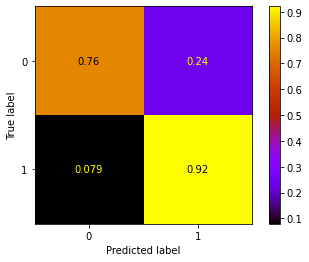

In [18]:
model = GradientBoostingClassifier(loss = params['loss'],
                                  learning_rate = params['learning_rate'],
                                  min_samples_split = params['min_samples_split'],
                                  min_samples_leaf = params['min_samples_leaf'],
                                  max_depth = params['max_depth'],
                                  max_features = params['max_features'],
                                  criterion = params['criterion'],
                                  subsample = params['subsample'],
                                  n_estimators = params['n_estimators'])

train, valid = train_model(model, "Gradient Boosting", X_train, y_train, X_valid, y_valid)
scores.loc['Gradient Boosting', ['Tuned Model'][0]].loc['Train'] = train
scores.loc['Gradient Boosting', ['Tuned Model'][0]].loc['Valid'] = valid

We observed a decrease in accuracy after hyperparameter tuning. This can be explained by the fact that instead of using our full parameter grid (commented out), we used the other one which required less time to run considering there were less candidates in it. Had we done the full parameter grid search, we could have got better accuracy too.

### 7. MLP Classifier

In [19]:
# Approx 5 mins to run
model = MLPClassifier()

# Running on reduced parameters because of computation constraints
param_grid = {'solver': ['sgd', 'adam'],
              'max_iter': [1700],
              'alpha': [0.001, 0.05],
              'activation': ["relu", "tanh"],
              'hidden_layer_sizes': [(100,1)]}

# param_grid = {'solver': ['lbfgs', 'sdm', 'adam'],
#               'learning_rate': ["constant", "adaptive"],
#               'max_iter': [1700,1800,1900,2000 ],
#               'alpha': 10.0 ** -np.arange(1, 7),
#               'activation': ["logistic", "relu", "tanh"]
#               'hidden_layer_sizes': [(100,1), (100,2), (100,3)],
#               'random_state':[6,7,8,9]}

grid_model = GridSearchCV(estimator=model, 
                 param_grid=param_grid, 
                 cv=5,   # 5-fold cross validation 
                 verbose=1, 
                 scoring='accuracy')

grid_model.fit(X_train, y_train)

params = grid_model.best_params_
print(params)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/home/ubuntu/project/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1700) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100, 1), 'max_iter': 1700, 'solver': 'sgd'}


Classifier :  MLP Classifier
Train Score:  0.876
Valid Score:  0.877

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87        62
           1       0.90      0.87      0.89        76

    accuracy                           0.88       138
   macro avg       0.88      0.88      0.88       138
weighted avg       0.88      0.88      0.88       138



Confusion Matrix



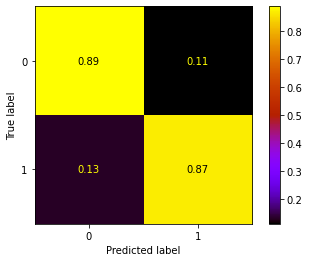

In [20]:
model = MLPClassifier(activation = params['activation'],
                     alpha = params['alpha'],
                     hidden_layer_sizes = params['hidden_layer_sizes'],
                     max_iter = params['max_iter'],
                     solver=params['solver'])
train, valid = train_model(model, "MLP Classifier", X_train, y_train, X_valid, y_valid)
scores.loc['MLP Classifier', ['Tuned Model'][0]].loc['Train'] = train
scores.loc['MLP Classifier', ['Tuned Model'][0]].loc['Valid'] = valid

Again, we observer a slight decrease in performance just as with the case of GradientBoosting. This is because we are not yet able to utilise these algorithms to their max performance via GridSearchCV due to the hardware and time limitations.

In [21]:
scores

Iteration         Base Model           Tuned Model          
Accuracy               Train     Valid       Train     Valid
GaussianNB          0.862821  0.862319    0.866667  0.869565
SVC                 0.917949  0.869565    0.924359  0.891304
KNN                 0.900000  0.884058    0.882051  0.876812
Decision Trees      1.000000  0.789855    0.896154  0.855072
Random Forest       1.000000  0.869565    0.934615  0.876812
Gradient Boosting   0.946154  0.869565    0.838462  0.847826
MLP Classifier      0.946154  0.869565    0.875641  0.876812

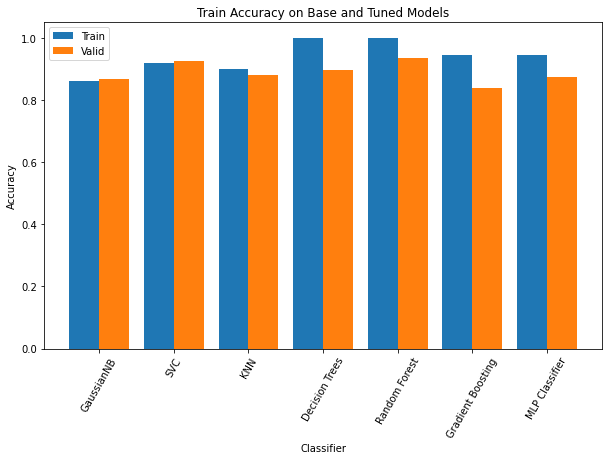

In [22]:
# Plot Base Model Train and Tuned Model Train Accuracy
x_axis = np.arange(len(scores.index))

plt.figure(figsize=(10,6))
plt.bar(x_axis - 0.2, scores['Base Model']['Train'].values, 0.4, label = 'Train')
plt.bar(x_axis + 0.2, scores['Tuned Model']['Train'].values, 0.4, label = 'Valid')
plt.xticks(x_axis, list(scores.index), rotation=60)
plt.xlabel("Classifier")
plt.ylabel("Accuracy")
plt.title("Train Accuracy on Base and Tuned Models")
plt.legend()
plt.show()

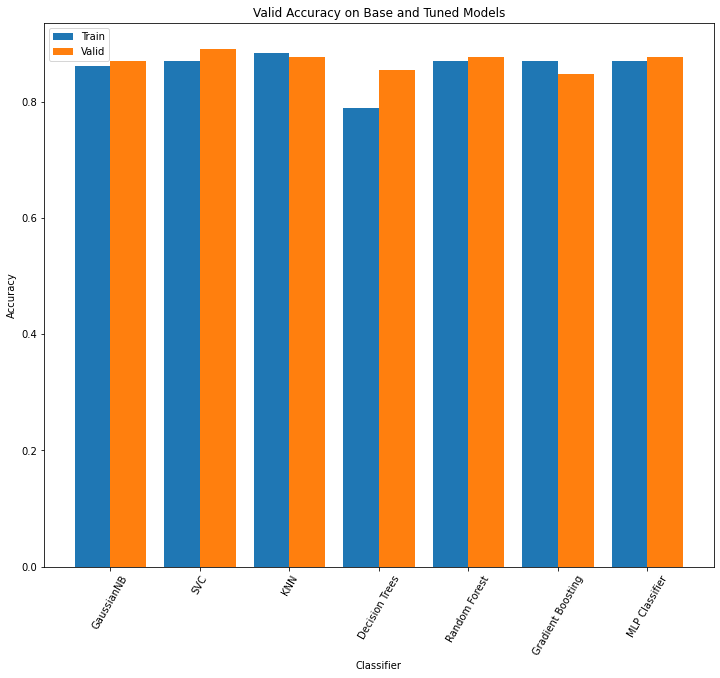

In [23]:
# Plot Base Model Train and Tuned Model Train Accuracy
x_axis = np.arange(len(scores.index))

plt.figure(figsize=(12, 10))
plt.bar(x_axis - 0.2, scores['Base Model']['Valid'].values, 0.4, label = 'Train')
plt.bar(x_axis + 0.2, scores['Tuned Model']['Valid'].values, 0.4, label = 'Valid')
plt.xticks(x_axis, list(scores.index), rotation=60)
plt.xlabel("Classifier")
plt.ylabel("Accuracy")
plt.title("Valid Accuracy on Base and Tuned Models")
plt.legend()
plt.show()

Almost all models show an increase in validation accuracy except for Gradient Boosting and MLP Classifier. The reason for the same has been specified above.

In [24]:
## Save multicolumn scores
buf = StringIO()
scores.to_csv(buf)

with open('data/scores-updated.csv', 'w') as file:
    buf.seek(0)
    shutil.copyfileobj(buf, file)